In [1]:
#Imports Libs
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import random
import pickle
import time
import pandas as pd

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, EarlyStopping
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

In [2]:
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])

In [3]:
#Dataset imports
dir = "img"
classes = os.listdir(dir)
classes_num = len(classes)

training_data = []

for sub in classes:
    path = os.path.join(dir, sub)
    class_index = classes.index(sub)

    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            training_data.append([img_array, class_index])
        except Exception as e:
            pass

random.shuffle(training_data)

In [4]:
#Create train & test set
X = []
y = []

for features, label in training_data:
    features = cv2.cvtColor(features, cv2.COLOR_BGR2GRAY)
    features = cv2.GaussianBlur(features,(3,3),cv2.BORDER_DEFAULT)
    features = cv2.Canny(features,0,75)
    X.append(features)
    y.append(label)




trainX = np.expand_dims(np.array(X), axis=3)
trainy = np.array(y)

#trainX, testX = X[:n_train], X[n_train:]
#trainy, testy = y[:n_train], y[n_train:]


#trainX = trainX.astype('float32')
#trainX = trainX / 255.

trainy_one_hot = to_categorical(trainy, classes_num)
#testy_one_hot = to_categorical(testy, classes_num)

trainX, validX, train_label, valid_label = train_test_split(trainX, trainy_one_hot, test_size=0.3, random_state=42)

## Model

In [5]:
trainX.shape[1:]

(300, 300, 1)

In [6]:
### Create MODEL

epochs = 100
batch_size = 32
es_callback = EarlyStopping(monitor='val_loss', patience=3)

model = Sequential(keras.layers.RandomRotation(
    factor=(-0.2, 0.3),
    fill_mode="reflect",
    interpolation="bilinear",
    seed=None,
    fill_value=0.0,
))


#Conv2D to extracts feature maps
model.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=trainX.shape[1:], padding='same', kernel_regularizer=l2(l=0.1)))
model.add(MaxPooling2D((2, 2),padding='same'))

model.add(Conv2D(64, (5,5), activation='relu', padding='same', kernel_regularizer=l2(l=0.1)))
#model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l=0.1)))
#model.add(LeakyReLU(alpha=0.01))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))

model.add(Dense(classes_num, activation='softmax'))
model.add(LeakyReLU(alpha=0.01))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

## Training Time :))

In [7]:
### TRAIN - CHOOO CHOOOO
history = model.fit(trainX, train_label, batch_size=batch_size, epochs=epochs, verbose=1, steps_per_epoch=trainX.shape[0] // batch_size, validation_data=(validX, valid_label), callbacks = es_callback)

Epoch 1/100
29/29 [==============================] - 19s 319ms/step - loss: 23.3608 - accuracy: 0.1606 - val_loss: 20.7350 - val_accuracy: 0.1667
Epoch 2/100
29/29 [==============================] - 9s 252ms/step - loss: 18.4336 - accuracy: 0.1799 - val_loss: 16.4139 - val_accuracy: 0.2083
Epoch 3/100
29/29 [==============================] - 7s 244ms/step - loss: 15.5541 - accuracy: 0.2028 - val_loss: 14.5588 - val_accuracy: 0.2083
Epoch 4/100
29/29 [==============================] - 7s 246ms/step - loss: 12.4435 - accuracy: 0.1897 - val_loss: 3.3672 - val_accuracy: 0.2034
Epoch 5/100
29/29 [==============================] - 7s 247ms/step - loss: 3.2283 - accuracy: 0.2126 - val_loss: 2.8676 - val_accuracy: 0.2475
Epoch 6/100
29/29 [==============================] - 8s 261ms/step - loss: 2.7193 - accuracy: 0.2912 - val_loss: 2.3969 - val_accuracy: 0.3627
Epoch 7/100
29/29 [==============================] - 7s 248ms/step - loss: 2.2593 - accuracy: 0.3697 - val_loss: 2.0149 - val_accuracy

In [8]:
#Save Model
modelname = 'edgedetect'
model.save(modelname + '.model')

INFO:tensorflow:Assets written to: edgedetect.model\assets


INFO:tensorflow:Assets written to: edgedetect.model\assets


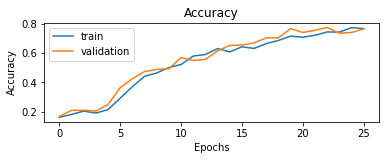

In [9]:
#GRAPHS :))))))
pd.DataFrame(history.history).plot()
plt.savefig(modelname + "_1.png")

plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(modelname + "_2.png")
plt.clf()


plt.subplot(211)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(modelname + "_3.png")

plt.show()

## Predict test

In [10]:
predictions = model.predict(X)

print("Test\t\tA\t\tB\t\tC\t\tD\t\tE\t\tI\t\tL\t\tO\t\tU\t\tY\t\tPredicted")
print("===========================================================================================================================")
predicted_classes = np.argmax(predictions, axis=1)

for i in range(len(predictions)):
    print(f"Test-{i+1:04d}\t{predictions[i][0]:2.2%}\t\t{predictions[i][1]:2.2%}\t\t\t{predictions[i][2]:2.2%}\t\t{predictions[i][3]:2.2%}\t\t{predictions[i][4]:2.2%}\t\t{predictions[i][5]:2.2%}\t\t{predictions[i][6]:2.2%}\t\t{predictions[i][7]:2.2%}\t\t{predictions[i][8]:2.2%}\t\t{predictions[i][9]:2.2%}\t\t{classes[y[i]]:}\t\t{classes[predicted_classes[i]]:}")
     
cm = metrics.confusion_matrix(y, predicted_classes)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.savefig("a-confmatrix.png")


ValueError: in user code:

    File "d:\Compiler\Python\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "d:\Compiler\Python\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Compiler\Python\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "d:\Compiler\Python\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "d:\Compiler\Python\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Compiler\Python\lib\site-packages\keras\engine\input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 300)
    
    Call arguments received by layer "sequential" (type Sequential):
      • inputs=('tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)', 'tf.Tensor(shape=(None, 300), dtype=uint8)')
      • training=False
      • mask=None


In [ ]:
trainy.shape

(1357,)

In [ ]:
cm = metrics.confusion_matrix(train_label, predicted_classes)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
np.argmax(train_label[1])

7

1/1 [==============================] - 0s 39ms/step
Test-0001	99.83%		0.17%			0.00%		0.00%		0.00%		0.00%		0.00%		0.00%		0.00%		0.00%		A		A
Prediction: A
Label: A


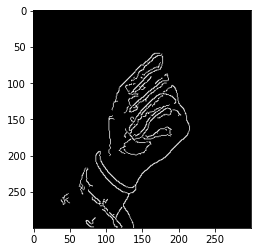

In [20]:
img_n = 12
test_image = trainX[img_n]
correct_label = np.argmax(train_label[img_n])
plt.imshow(test_image, cmap='gray')
test_image = np.expand_dims(test_image, axis = 0)
#test_image = test_image.astype('float32')/255
predictions = model.predict(test_image)
predicted_classes = np.argmax(predictions, axis=1)
for i in range(len(predictions)):
    print(f"Test-{i+1:04d}\t{predictions[i][0]:2.2%}\t\t{predictions[i][1]:2.2%}\t\t\t{predictions[i][2]:2.2%}\t\t{predictions[i][3]:2.2%}\t\t{predictions[i][4]:2.2%}\t\t{predictions[i][5]:2.2%}\t\t{predictions[i][6]:2.2%}\t\t{predictions[i][7]:2.2%}\t\t{predictions[i][8]:2.2%}\t\t{predictions[i][9]:2.2%}\t\t{classes[correct_label]:}\t\t{classes[predicted_classes[i]]:}")
    

print("Prediction:", classes[predicted_classes[0]])
print("Label:", classes[correct_label])